In [1]:
###-----------------
### Import Libraries
###-----------------
import sys


sys.path.append('../')
 

import os
import gc
import time
import numpy as np
import pandas as pd
import seaborn as sns
from torchsummary import summary
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, mean_squared_error


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Global variables
inpDir = '../input' # Input Stored here
outDir = '../ouput' # output Here
modelDir = './models'# to save Models
subDir = 'fifa_2019' # sub dir by dataset
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)



BATCH_SIZE = 64
NOISE = 0.2 
ALPHA = 0.001 
EPOCHS = 30
TEST_SIZE = 0.2

In [4]:
#set the plotting parameters
params = {
    'legend.fontsize': 'medium',
    'figure.figsize':(15,6),
    'axes.labelsize':'medium',
    'axes.titlesize':'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize':'medium',
    #'text.usetex':True,
}
plt.rcParams.update(params)
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


$$\text{
    Load Weather Data
}$$

In [5]:
fileName = 'weatherHistory.csv'
data_df = pd.read_csv(os.path.join(inpDir,fileName))
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [6]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc=True)

In [7]:
num_cols = [
    'Temperature (C)', 
    'Humidity', 
    'Wind Speed (km/h)',
    'Wind Bearing (degrees)', 
    'Visibility (km)', 
    'Pressure (millibars)', 
]

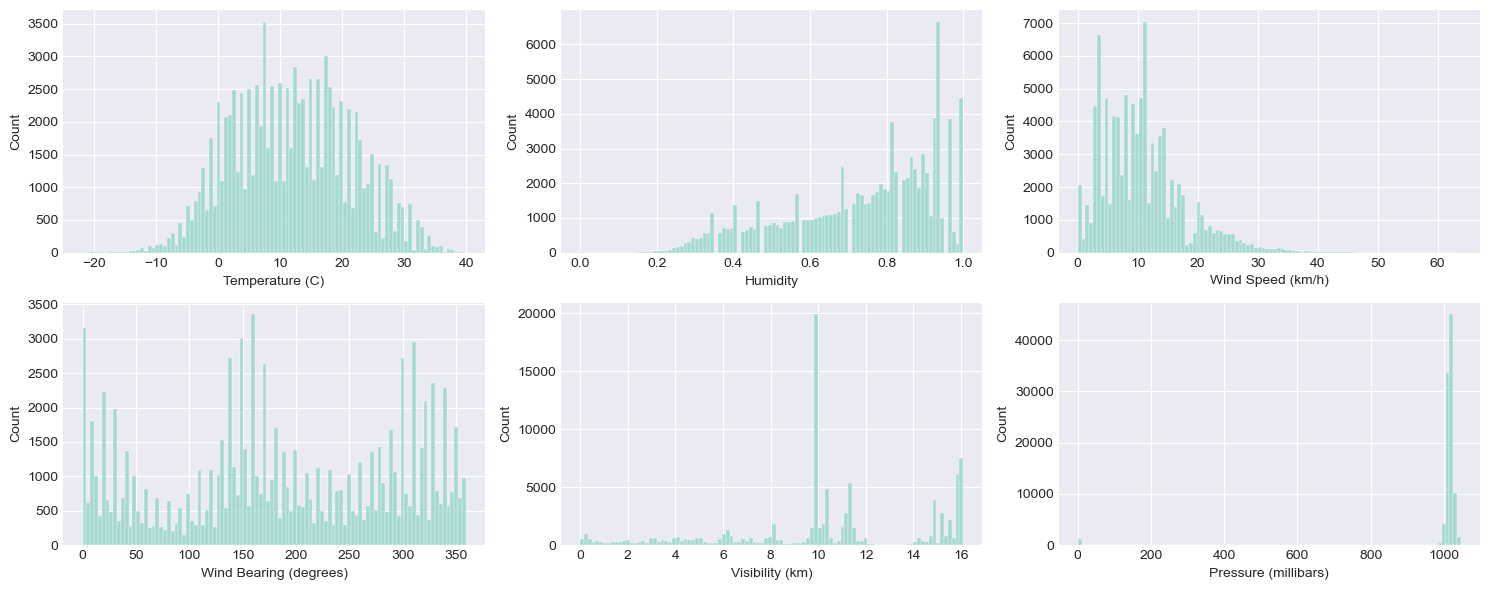

In [8]:
fig, axes = plt.subplots(2,3)

nbin = 100
axes = axes.ravel()

for count, col in enumerate(num_cols):
    ax = axes[count]
    sns.histplot(data=data_df, x=col,ax=ax, bins=nbin)

plt.tight_layout()
plt.show()

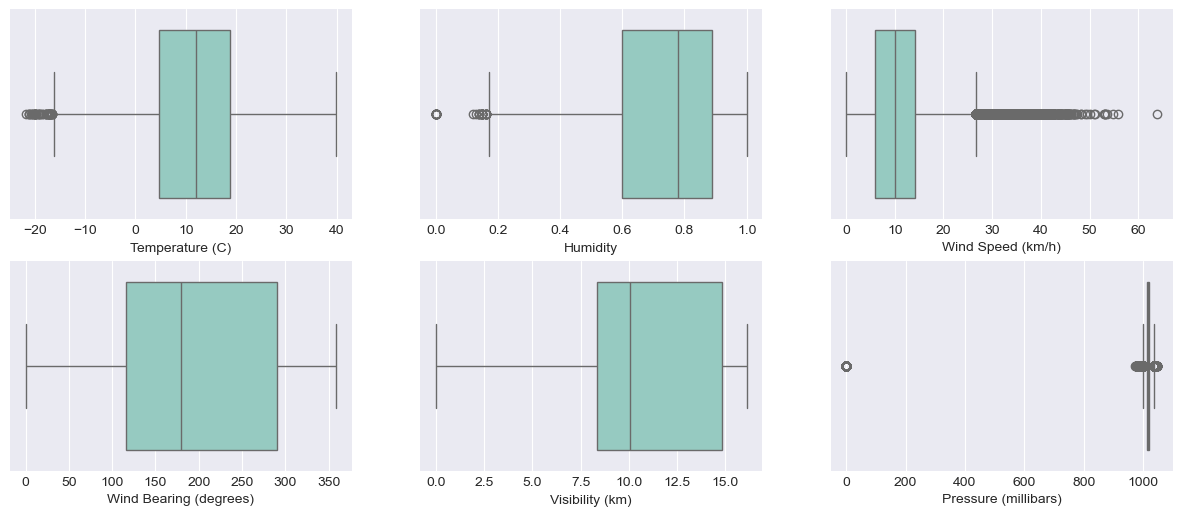

In [9]:
fig, axes = plt.subplots(2,3)

axes = axes.ravel()

for count, col in enumerate(num_cols):
    ax = axes[count]
    sns.boxplot(data=data_df, x=col,ax=ax)

plt.show()

<Axes: >

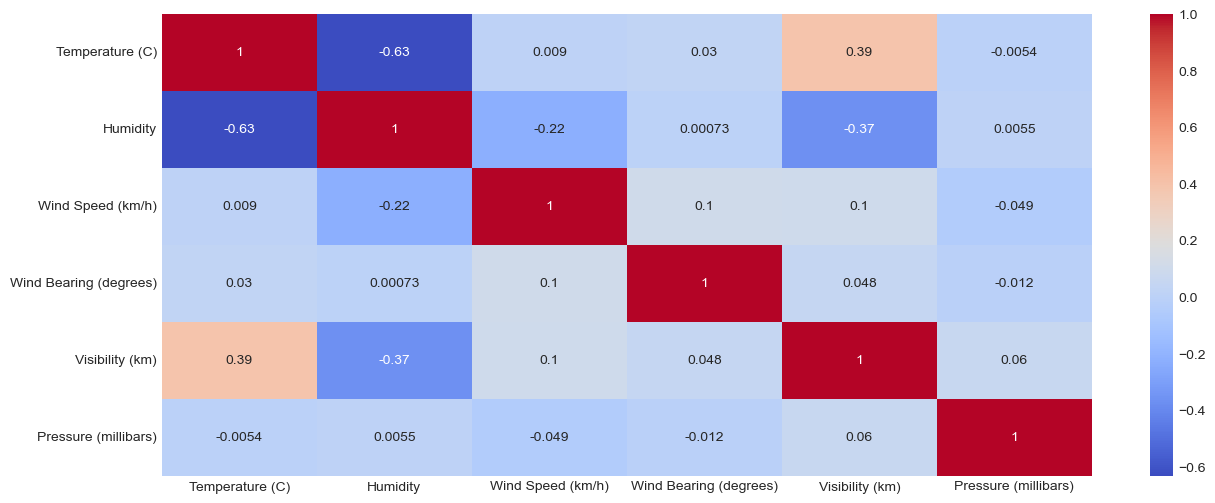

In [10]:
sns.heatmap(data=data_df[num_cols].corr(), annot=True, cmap=CMAP)

In [11]:
data_df['datetime']

0       2006-03-31 22:00:00+00:00
1       2006-03-31 23:00:00+00:00
2       2006-04-01 00:00:00+00:00
3       2006-04-01 01:00:00+00:00
4       2006-04-01 02:00:00+00:00
                   ...           
96448   2016-09-09 17:00:00+00:00
96449   2016-09-09 18:00:00+00:00
96450   2016-09-09 19:00:00+00:00
96451   2016-09-09 20:00:00+00:00
96452   2016-09-09 21:00:00+00:00
Name: datetime, Length: 96453, dtype: datetime64[ns, UTC]

In [12]:
temp_df = data_df[['datetime', 'Temperature (C)']]
temp_df = temp_df.sort_values(by=['datetime'], axis=0, ascending=True)
temp_df = temp_df.reset_index(drop=True)
temp_df.rename({
    'Temperature (C)': 'temp'
}, axis=1, inplace=True)

temp_df.head()


,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


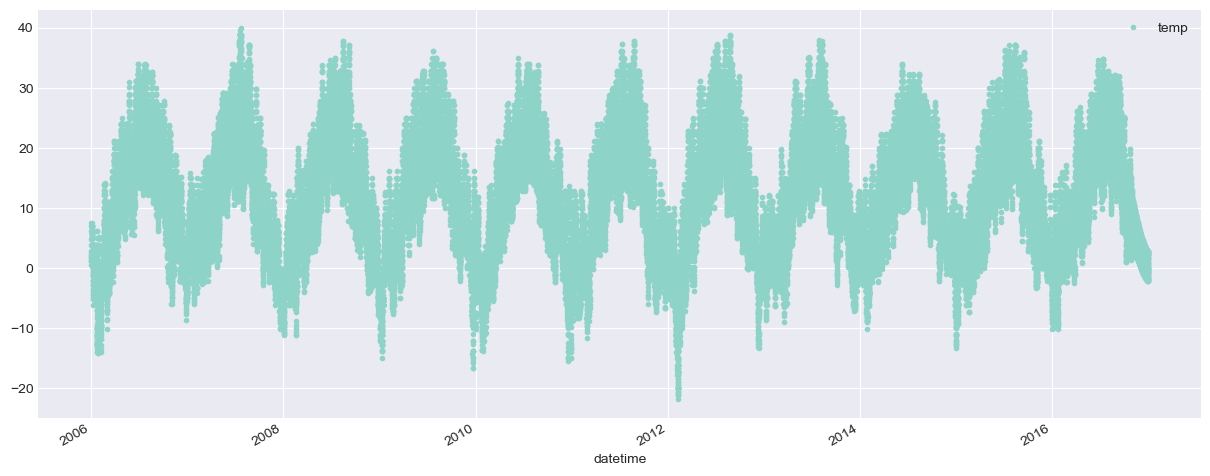

In [13]:
ax = temp_df.plot(x='datetime', y='temp', style='.')

In [14]:
h_units= 100
input_shape = (1,10000)

model = tf.keras.Sequential()

model.add(
    tf.keras.layers.Input(
        shape=input_shape
    )
)

model.add(
    tf.keras.layers.SimpleRNN(
        units=h_units,
        activation='tanh'
    )
)

model.add(
    tf.keras.layers.Dense(
        1,
        activation='linear'
    )
)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 100)            │     1,010,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,201 (3.85 MB)

 Trainable params: 1,010,201 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# for ax in model.get_weights():
#     print(ax.shape)



print(f'Wax = {model.get_weights()[0].shape}')
print(f'Waa = {model.get_weights()[1].shape}')
print(f'ba = {model.get_weights()[2].shape}')
print(f'Way = {model.get_weights()[3].shape}')
print(f'by = {model.get_weights()[4].shape}')


Wax = (10000, 100)
Waa = (100, 100)
ba = (100,)
Way = (100, 1)
by = (1,)


---
$$
\text{Building Actual Model}
$$

In [17]:
time_step = 24
temp_df.shape[0]/time_step

y_idx = np.arange(time_step, temp_df.shape[0], time_step)

y_df = temp_df.iloc[y_idx]
X_df = temp_df.iloc[range(len(y_df)*time_step)]
display(X_df.shape)
y_df.head()


X = np.reshape(X_df['temp'].values, (y_df.shape[0], time_step))
X.shape, y_df.shape

(96432, 2)

((4018, 24), (4018, 2))

In [18]:
# Remove last Column
X = X[:,:23]
X.shape

(4018, 23)

In [19]:
y_df.head()

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


[sample, timesteps, features] 
    

In [20]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape

(4018, 23, 1)

In [21]:
split = int(y_df.shape[0] * (1-TEST_SIZE))
split

3214

In [31]:
h_units= 256
input_shape = (time_step-1,1)

initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

model = tf.keras.Sequential()

model.add(
    tf.keras.layers.Input(
        shape=input_shape
    )
)

model.add(
    tf.keras.layers.SimpleRNN(
        units=h_units,
        activation='tanh',
        kernel_initializer = initializer
    )
)

model.add(
    tf.keras.layers.Dense(
        1,
        activation='linear',
        kernel_initializer = initializer
    )
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 256)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,305 (259.00 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(f'Wax = {model.get_weights()[0].shape}')
print(f'Waa = {model.get_weights()[1].shape}')
print(f'ba = {model.get_weights()[2].shape}')
print(f'Way = {model.get_weights()[3].shape}')
print(f'by = {model.get_weights()[4].shape}')


Wax = (1, 256)
Waa = (256, 256)
ba = (256,)
Way = (256, 1)
by = (1,)


In [32]:
X_train = X[:split]
X_test = X[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3214, 23, 1), (804, 23, 1), (3214,), (804,))

In [33]:
model.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error',
    metrics = [tf.keras.metrics.RootMeanSquaredError(
        name='RMSE'
    )]
)

In [34]:
history = model.fit(
    x=X_train,
    y=y_train, 
    validation_data = [X_test, y_test],
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS
)

Epoch 1/30


51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - RMSE: 1.5799 - loss: 2.5909 - val_RMSE: 0.8393 - val_loss: 0.7044
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - RMSE: 1.0542 - loss: 1.1128 - val_RMSE: 0.8584 - val_loss: 0.7369
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - RMSE: 1.0445 - loss: 1.0925 - val_RMSE: 0.8414 - val_loss: 0.7080
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - RMSE: 1.0455 - loss: 1.0945 - val_RMSE: 0.8296 - val_loss: 0.6882
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - RMSE: 1.0407 - loss: 1.0848 - val_RMSE: 0.8708 - val_loss: 0.7583
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - RMSE: 1.0461 - loss: 1.0958 - val_RMSE: 0.8292 - val_loss: 0.6876
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - RMSE: 1.0378 - loss: 1.0784 - val_RMSE: 0.8346 - val_loss: 0.6965
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - RMSE: 1.0430 - loss: 1.0891 - val_RMSE: 0.8396 - val_loss: 0.7049
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - RMSE: 

In [35]:
hist_df = pd.DataFrame(history.history)

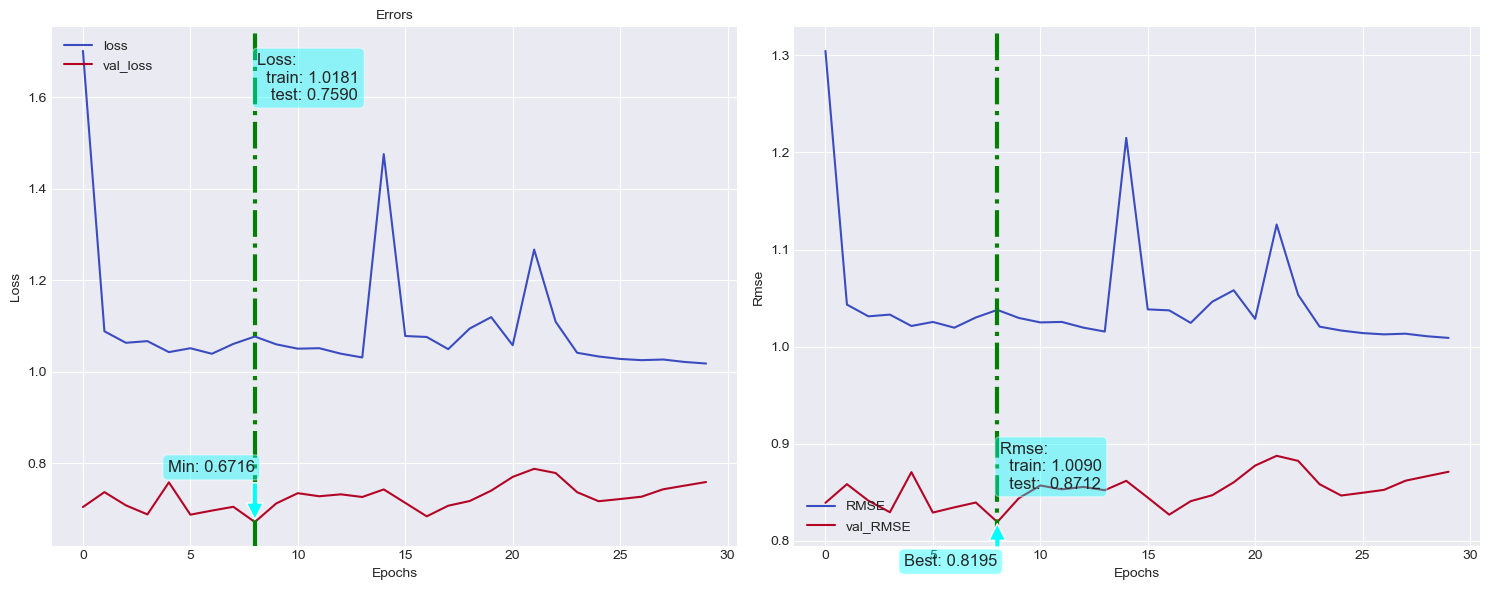

In [36]:
from utils.helper import fn_plot_tf_hist

fn_plot_tf_hist(hist_df)

In [38]:
y_tr_pred = model.predict(X_train)
y_ts_pred = model.predict(X_test)
y_pred = np.append(y_tr_pred,y_ts_pred)


res_df = y_df.copy()
res_df['pred'] = y_pred
res_df


101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


,datetime,temp,pred
24,2006-01-01 23:00:00+00:00,5.422222,4.288876
48,2006-01-02 23:00:00+00:00,1.694444,1.934423
72,2006-01-03 23:00:00+00:00,2.200000,2.226664
96,2006-01-04 23:00:00+00:00,1.666667,2.148588
120,2006-01-05 23:00:00+00:00,1.805556,2.575484
...,...,...,...
96336,2016-12-27 02:00:00+00:00,-1.627778,-1.618998
96360,2016-12-28 02:00:00+00:00,-1.677778,-1.666192
96384,2016-12-29 02:00:00+00:00,-1.727778,-1.713693
96408,2016-12-30 02:00:00+00:00,-1.777778,-1.761756


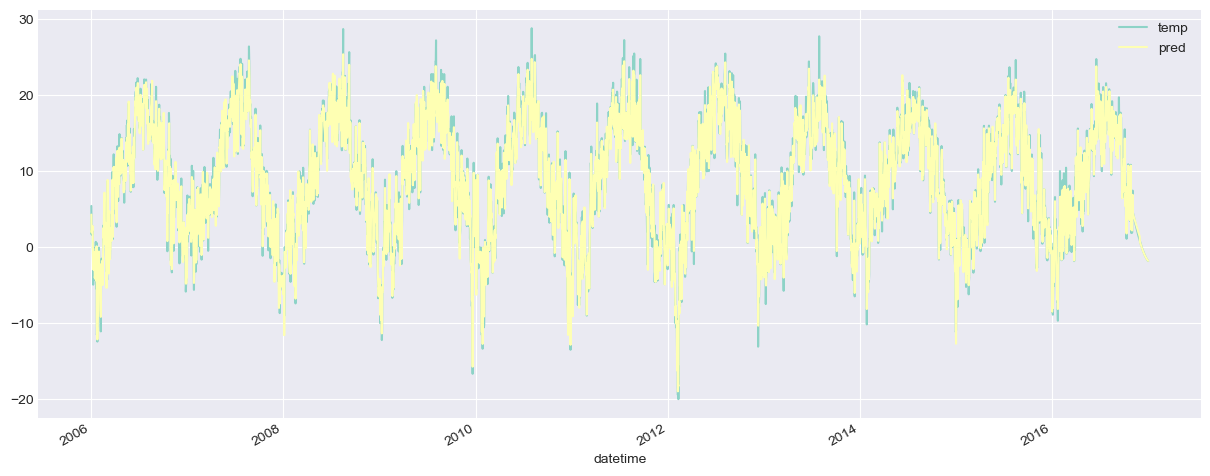

In [40]:
res_df.plot(x='datetime', y=['temp', 'pred'])
plt.show()

```python
y = [𝑥ₜ (1,10000) * 𝑊ₕₓ (10000, 100) + 𝑊ₕₕ (100, 100) * hₜ (100, 1) + 𝑏ₕ (100, 1)] * 𝑊ᵧₕ (1, 100) + 𝑏ᵧ (1, 1)
```